# Model1 CNN+LSTM
version 0.1.b.3

## Implementation detals
- Input size: -1 x 2 x 30 x 3 x 100
- Output size: -1 x 3
<br></br>
- X: CSI (magnitude + phase)(3-D)
- Y: side label (one-hot)
## Version Info
- Mapping from CSI to side labels
- Only uses dynamic data
- 3D convolution on CSI
- Applied GlobalAveragePooling

In [1]:
# Imports
# !pip install torchinfo
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

## Model

In [2]:
class MyEncodeCNN(nn.Module):
    def __init__(self):
        super(MyEncodeCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, stride=(1, 1, 1), padding=(0, 0, 1)),
            nn.BatchNorm3d(16),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 100 * 30 * 3 * 1
            # Out = 98 * 28 * 3 * 16
        )

        self.layer2 = nn.Sequential(
            nn.Conv3d(16, 32, kernel_size=3, stride=(1, 1, 1), padding=(0, 0, 1)),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 98 * 28 * 3 * 16
            # Out = 96 * 26 * 3 * 32
        )

        self.layer3 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=3, stride=(1, 1, 1), padding=(0, 0, 1)),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 96 * 26 * 3 * 32
            # Out = 94 * 24 * 3 * 64
        )

        self.layer4 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, stride=(1, 1, 1), padding=(0, 0, 1)),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 94 * 24 * 3 * 64
            # Out = 92 * 22 * 3 * 128
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=3, stride=(1, 1, 1), padding=(0, 0, 1)),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 92 * 22 * 3 * 128
            # Out = 90 * 20 * 3 * 256
        )
        
        self.layer6 = nn.Sequential(
            nn.Conv3d(256, 512, kernel_size=3, stride=(1, 1, 1), padding=(0, 0, 1)),
            nn.BatchNorm3d(512),
            nn.LeakyReLU(inplace=True),
            # No Padding
            # No Pooling
            # In = 90 * 20 * 3 * 256
            # Out = 88 * 18 * 3 * 512
        )

        self.layerfc = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 128)
        )
        
        self.gap = nn.Sequential(
            nn.AvgPool3d(kernel_size=(88, 18, 3), stride=1, padding=0)
        )

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.gap(x)

        # size_x = batch_size * 1024
        # x = self.dropout(x)
        # x = self.layerfc(x)
        return x

class MyEncoder(nn.Module):
    def __init__(self):
        super(MyEncoder, self).__init__()
        
        self.cnn1 = MyEncodeCNN()
        self.cnn2 = MyEncodeCNN()

    def forward(self, x):
        x = torch.chunk(x.view(-1, 2, 100, 30, 3), 2, dim=1)
        x1 = self.cnn1.forward(x[0].view(-1, 1, 100, 30, 3))
        x2 = self.cnn2.forward(x[1].view(-1, 1, 100, 30, 3))

        # size_x = batch_size * 512

        out = torch.cat([x1, x2], dim=1)
        #size_out = batch_size * 1024
        
        return out


class MyDecodeFC(nn.Module):
    def __init__(self):
        super(MyDecodeFC, self).__init__()

        self.fclayers = nn.Sequential(
            nn.Linear(1024, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),)
        
        self.onehotout = nn.Sequential(
            nn.Linear(4096, 3),
         )
        
        self.singleout = nn.Sequential(
            nn.Linear(4096, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fclayers(x)
        x = self.onehotout(x)
        return x


class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.encoder = MyEncoder()
        self.decoder = MyDecodeFC()

    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z.view(-1, 1024)) 
        return y

In [3]:
m1 = MyModel()
summary(m1, input_size=(2, 100, 30, 3))

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [1, 3]                    --
├─MyEncoder: 1-1                         [1, 1024, 1, 1, 1]        --
│    └─MyEncodeCNN: 2-1                  --                        2,625,664
│    │    └─Sequential: 3-1              [1, 16, 98, 28, 3]        480
│    │    └─Sequential: 3-2              [1, 32, 96, 26, 3]        13,920
│    │    └─Sequential: 3-3              [1, 64, 94, 24, 3]        55,488
│    │    └─Sequential: 3-4              [1, 128, 92, 22, 3]       221,568
│    │    └─Sequential: 3-5              [1, 256, 90, 20, 3]       885,504
│    │    └─Sequential: 3-6              [1, 512, 88, 18, 3]       3,540,480
│    │    └─Sequential: 3-7              [1, 512, 1, 1, 1]         --
│    └─MyEncodeCNN: 2-2                  --                        2,625,664
│    │    └─Sequential: 3-8              [1, 16, 98, 28, 3]        480
│    │    └─Sequential: 3-9              [1,

## Dataset

In [4]:
# My Dataset

class MyDataset(Data.Dataset):
    def __init__(self, x_path, y_path, number=0):
        self.seeds = None
        self.data = self.load_data(x_path, y_path, number=number)
        print('loaded')

    def __getitem__(self, index):
        return self.data['x'][index], self.data['y'][index]

    def __len__(self):
        return self.data['x'].shape[0]

    def load_data(self, x_path, y_path, number):
        x = np.load(x_path)
        y = np.load(y_path)

        if x.shape[0] == y.shape[0]:
            total_count = x.shape[0]
        else:
            print(x.shape, y.shape, "lengths not equal!")
            
        if number != 0:
            picked = np.random.choice(list(range(total_count)), size=number, replace=False)
            self.seeds = picked
            x = x[picked]
            y = y[picked]

        return {'x':x, 'y':y}
    
def split_loader(dataset, train_size, valid_size, test_size, batch_size):
    train_dataset, valid_dataset, test_dataset = Data.random_split(dataset, [train_size, valid_size, test_size])
    print(len(train_dataset), len(valid_dataset), len(test_dataset))
    train_loader = Data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    valid_loader = Data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = Data.DataLoader(test_dataset, batch_size=1, shuffle=True)
    return train_loader, valid_loader, test_loader

In [5]:
datadir = '../Dataset/0221make00/'
print(os.listdir(datadir))

['sid_oh.npy', 'csi.npy', '.ipynb_checkpoints']


In [6]:
mydata = MyDataset(datadir + 'csi.npy', datadir + 'sid_oh.npy')
print(mydata.data['x'].shape, mydata.data['y'].shape)

train_size = int(len(mydata) * 0.7)
valid_size = int(len(mydata) * 0.2)
test_size = int(len(mydata)) - train_size - valid_size
print(train_size, valid_size, test_size)

train_loader, valid_loader, test_loader = split_loader(mydata, train_size, valid_size, test_size, 64)

loaded
(3000, 2, 100, 30, 3) (3000, 3)
2100 600 300
2100 600 300


In [7]:
torch.cuda.get_device_name(0)

'GeForce GTX TITAN X'

## Running gears

In [8]:
# Hyperparameters

class MyArgs:
    def __init__(self, epochs=10, learning_rate=0.001):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

args = MyArgs(epochs=300, learning_rate=0.1)

In [9]:
# Model and Loss

model = MyModel().to(args.device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

train_loss = []
valid_loss = []
train_epochs_loss = []
valid_epochs_loss = []

# early_stopping = EarlyStopping(patience=args.patience,verbose=True)

In [10]:
# Training and Saving
start = time.time()

for epoch in range(args.epochs):
    model.train()
    train_epoch_loss = []
    for idx,(data_x,data_y) in enumerate(train_loader,0):
        data_x = data_x.to(torch.float32).to(args.device)
        data_y = data_y.to(torch.long).to(args.device)
        optimizer.zero_grad()
        outputs = model(data_x)
        loss = criterion(outputs, data_y)
        loss.backward()
        optimizer.step()
        train_epoch_loss.append(loss.item())
        train_loss.append(loss.item())
        if idx%(len(train_loader)//2)==0:
            print("\repoch={}/{},{}/{}of train, loss={}".format(
            epoch, args.epochs, idx, len(train_loader),loss.item()),   end='')
    train_epochs_loss.append(np.average(train_epoch_loss))
  
end = time.time()
print("\nTotal training time:", end-start, "sec")

epoch=299/300,16/32of train, loss=0.2222222089767456
Total training time: 51250.37442827225 sec


In [14]:
torch.save(model.state_dict(), '../Models/v01b3_ep300.pth')

In [13]:
  #=====================valid============================
model.eval()
valid_epoch_loss = []
for idx,(data_x,data_y) in enumerate(valid_loader,0):
    data_x = data_x.to(torch.float32).to(args.device)
    data_y = data_y.to(torch.long).to(args.device)
    outputs = model(data_x)
    loss = criterion(outputs,data_y)
    valid_epoch_loss.append(loss.item())
    valid_loss.append(loss.item())
valid_epochs_loss.append(np.average(valid_epoch_loss))

  #==================early stopping======================
  # early_stopping(valid_epochs_loss[-1],model=MyModel,path=r'')
  # if early_stopping.early_stop:
  #    print("Early stopping")
  #    break
  #====================adjust lr========================
lr_adjust = {
    2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
    10: 5e-7, 15: 1e-7, 20: 5e-8
}
  #if epoch in lr_adjust.keys():
  #    lr = lr_adjust[epoch]
  #    for param_group in optimizer.param_groups:
  #        param_group['lr'] = lr
  #    print('Updating learning rate to {}'.format(lr))



RuntimeError: CUDA out of memory. Tried to allocate 594.00 MiB (GPU 0; 11.92 GiB total capacity; 10.34 GiB already allocated; 286.31 MiB free; 10.69 GiB reserved in total by PyTorch)

## Visualization of Training Process

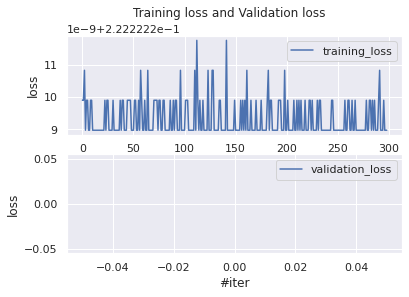

In [17]:
# Plot loss curves

%matplotlib inline
plt.clf()
plt.suptitle("Training loss and Validation loss")
plt.subplot(2, 1, 1)
plt.plot(train_epochs_loss[1:], 'b', label = 'training_loss')
plt.ylabel('loss')
plt.xlabel('#epoch')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(valid_loss, 'b', label = 'validation_loss')
plt.ylabel('loss')
plt.xlabel('#iter')
plt.legend()
#plt.savefig("loss_900epoch_down.jpg")

In [24]:
print(np.array(train_epochs_loss).shape, np.array(valid_epochs_loss).shape)
print(np.array(train_loss).shape, np.array(valid_loss).shape)

(600,) (2,)
(22800,) (20,)


## Load from checkpoint

In [ ]:
# If you want to train from a certain checkpoint

#model = torch.load('../Models/v0_ep500_lr001.pth')
model.load_state_dict(torch.load('../Models/v0_ep500_lr001.pth'))
model.cuda()

# Reload the loss curve
preserve = 500
# 3 iter per epoch
train_loss = train_loss[:preserve * 3]
# discard following epoch values
train_epochs_loss = train_epochs_loss[:preserve]

# re-validate
valid_loss = []
valid_epochs_loss = []

args = MyArgs(epochs=200, learning_rate=0.0001)

## Estimation
Test performance

In [15]:
  #=====================test============================
estimate = []
test_loss = []
ground_truth = []
model.eval()
for idx,(data_x,data_y) in enumerate(test_loader,0):
    data_x = data_x.to(torch.float32).to(args.device)
    data_y = data_y.to(torch.long).to(args.device)
    outputs = model(data_x)
    loss = criterion(outputs,data_y)
    estimate.append(outputs.cpu().detach().numpy().squeeze().tolist())
    ground_truth.append(data_y.cpu().detach().numpy().squeeze().tolist())
    test_loss.append(loss.item())
    if idx%(len(test_loader)//5)==0:
        print("{}/{}of test, loss={}".format(
        idx, len(test_loader),loss.item()))

0/300of test, loss=0.2222222089767456
60/300of test, loss=0.2222222089767456
120/300of test, loss=0.2222222089767456


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 11.92 GiB total capacity; 10.85 GiB already allocated; 8.31 MiB free; 10.96 GiB reserved in total by PyTorch)

Confusion matrix

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
%matplotlib inline

def fromonehot(inlist):
    out = []
    for item in inlist:
        if np.argmax(item) == 0:
            out.append(-1)
        elif np.argmax(item) == 1:
            out.append(0)
        elif np.argmax(item) == 2:
            out.append(1)
    return out


_, predicted = torch.max(estimate, 1)
_, ground_t = torch.max(ground_truth, 1)
print(ground_t, predicted)

plt.figure()
sns.set()
f,ax=plt.subplots()
cf = confusion_matrix(ground_t, predicted)

sns.heatmap(cf,annot=True,ax=ax) 

ax.set_title('confusion matrix') 
ax.set_xlabel('predict') 
ax.set_ylabel('true')

TypeError: max() received an invalid combination of arguments - got (list, int), but expected one of:
 * (Tensor input)
 * (Tensor input, name dim, bool keepdim, *, tuple of Tensors out)
 * (Tensor input, Tensor other, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, tuple of Tensors out)


In [ ]:
%matplotlib inline
data = torch.tensor(csis, dtype=torch.float32, device='cuda:1')
for i in range(len(data)):
    predictions = model(data[i])
    pred = predictions.cpu().detach().numpy()[0, 0]
    plt.figure()
    plt.imshow(pred)
    plt.show()